In [1]:
import time

import pandas as pd 
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import imblearn
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import make_pipeline

import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn import neighbors, svm, tree, linear_model, ensemble, neural_network, metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score, cohen_kappa_score,\
classification_report, log_loss
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.pipeline import Pipeline 
#########################################################################

%matplotlib inline
pd.set_option("max_columns",90, "max_rows", 90)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# read data
raw_df = pd.read_csv('Gse_panel_current_sample_raw.csv')

In [3]:
def model_fit(clf, X_train, X_test, y_train, y_test, display=False):
    clf.fit(X_train, y_train)
    # y_pred = clf.predict(X_test)
    
    y_pred = (clf.predict_proba(X_test)[:, 1] > 0.5).astype(int)
    
    if display:
        print(f"Accuracy = {accuracy_score(y_test, y_pred)}")
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

        # ROC - AUC  
        conf_score = clf.decision_function(X_test)    # print(roc_auc_score(y_test, conf_score))    
        fpr, tpr, _ = roc_curve(y_test, conf_score)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC - LR')
        plt.legend(loc="lower right")
        plt.show()

        # PR AUC  
        conf_score = clf.decision_function(X_test)    # print(roc_auc_score(y_test, conf_score))    
        precision, recall, _ = precision_recall_curve(y_test, conf_score)
        plt.figure()
        plt.plot(recall, precision, color='darkorange', lw=1, label='PR curve (area = %0.3f)' % average_precision_score(y_test, conf_score))
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall(True Positive Rate)')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')
        plt.legend(loc="upper right")
        plt.show()

        # cohen's kappa: how well the classifier performed as compared to how well it would have performed simply by chance
        print("cohen's kappa: ", cohen_kappa_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
    return y_pred

In [4]:
def data_prep(raw_df):
    #################################################
    #                 missing data                  #
    #################################################
    # fill in the missing msa
    # missing msa --> corresponding prop_state x
    # prop_state x --> find the most frequent msa in that state ==> sta_msa, a dict {state_name: most frequent msa in that state}
    # use sta_msa to fill in the missing msa
    sta_msa = {}
    for state, group in raw_df[['prop_state', 'msa']].groupby('prop_state'):
        sta_msa[state] = group['msa'].value_counts().idxmax()
    raw_df['msa'] = raw_df[['prop_state', 'msa']].apply(lambda row: sta_msa[row['prop_state']] if np.isnan(row['msa']) else row['msa'], axis = 1)

    # fill in the missing num_bo and num_unit with their median respectively 
    raw_df['num_bo'].fillna(raw_df['num_bo'].median(), inplace=True)
    raw_df['num_unit'].fillna(raw_df['num_unit'].median(), inplace=True)

    # drop the training sample with missing data in status column
    df = raw_df.dropna(how='any').copy()
    
    df['status'] = df['status'].apply(lambda x: int(x=='D60-D90'))
    
    X = df.drop(['loan_id', 'status', 'status_prev'], axis=1).copy()
    X.drop(['prop_state'], axis=1, inplace=True)
#   X.drop(['prop_state', 'oltv', 'oyr', 'orig_rt', 'orig_upb', 'avg_upb', 'year', 'oqtr'], axis=1, inplace=True)
#   golden_features = ['fico', 'ur', 'CLTV', 'dti', 'loan_age_qtr', 'HPI_O']
#   X = X[golden_features]
#   X.drop(['pmms_o', 'HPI'], axis=1, inplace=True)
#   X.drop(['loan_purp', 'fhb_flag', 'occ_stat', 'prop_type'], axis=1, inplace=True)
    X = pd.get_dummies(X)
    
    # perform log transformation for the highly skewed features
    X_num = X.select_dtypes(include=['float64', 'int64'])
    skewed_feat = X_num.skew()
    skewed_idx = skewed_feat[skewed_feat.abs() > 2].index
    X[skewed_idx] = X[skewed_idx].transform(np.log)

    # feature engineering
#    X['HPI_diff'] = X['HPI'] - X['HPI_O']
#    X['PMMS_diff'] = X['PMMS'] - X['pmms_o']
#    X['LTV_diff'] = X['CLTV'] - X['oltv']
#    X['dti_CLTV'] = X['dti'] * X['CLTV']
#    X['fico'] = X['fico']**2
    
    y = df['status'].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    return (X_train, X_test, y_train, y_test)

## Over-sampling via SMOTE

In [5]:
# split sample set
X_train, X_test, y_train, y_test = data_prep(raw_df)
X_train = X_train.values
y_train = y_train.values

# over-sampling
sm = SMOTE(ratio='minority', random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)

In [6]:
X_res.shape

(1396898, 45)

Accuracy = 0.99784


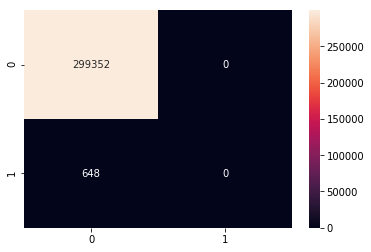

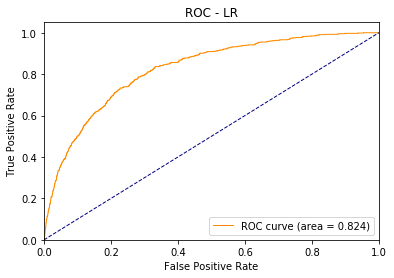

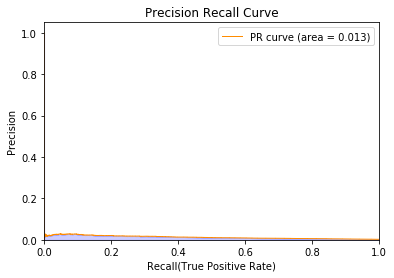

cohen's kappa:  0.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    299352
          1       0.00      0.00      0.00       648

avg / total       1.00      1.00      1.00    300000



C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
clf = linear_model.LogisticRegression(penalty='l2', C=1)
y_pred = model_fit(clf, X_train, X_test, y_train, y_test, display=True)

Accuracy = 0.7917833333333333


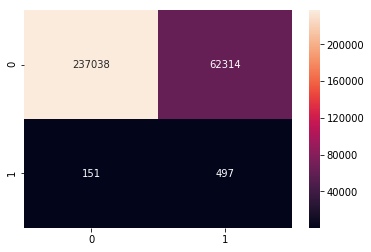

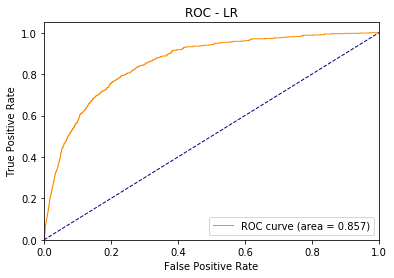

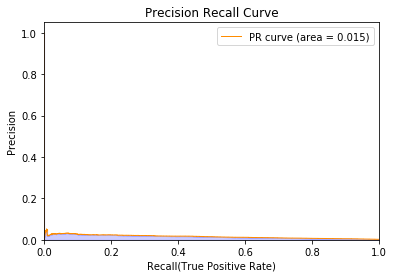

cohen's kappa:  0.011436671657996
             precision    recall  f1-score   support

          0       1.00      0.79      0.88    299352
          1       0.01      0.77      0.02       648

avg / total       1.00      0.79      0.88    300000



In [7]:
# LR
clf = linear_model.LogisticRegression(penalty='l2', C=1)
y_pred = model_fit(clf, X_res, X_test, y_res, y_test, display=True)

In [11]:
clf.predict_proba(X_res)

array([[0.96307142, 0.03692858],
       [0.78947204, 0.21052796],
       [0.89744498, 0.10255502],
       ...,
       [0.3865914 , 0.6134086 ],
       [0.38002981, 0.61997019],
       [0.43983951, 0.56016049]])

### GradientBoost 

Accuracy = 0.96778


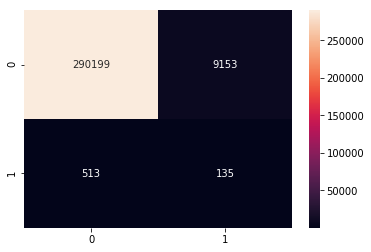

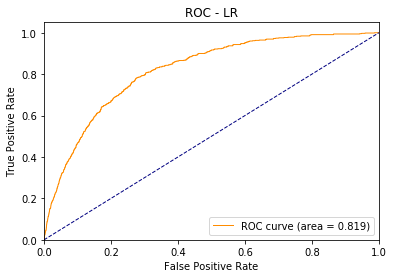

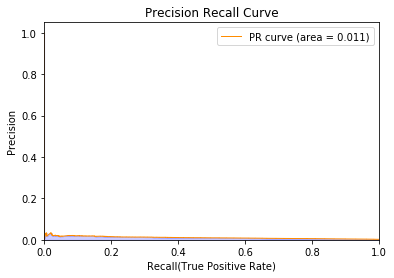

cohen's kappa:  0.02322945878835936
             precision    recall  f1-score   support

          0       1.00      0.97      0.98    299352
          1       0.01      0.21      0.03       648

avg / total       1.00      0.97      0.98    300000



In [51]:
# GB
params = {'n_estimators': 20, 'min_samples_split': 1200, 'min_samples_leaf': 60, 'max_features': 23, 'max_depth': 4, 'learning_rate': 0.1, 'random_state': 0}
gb = GradientBoostingClassifier(**params)
y_pred = model_fit(gb, X_res, X_test, y_res, y_test, display=True)

Text(0,0.5,'Feature Importance Score')

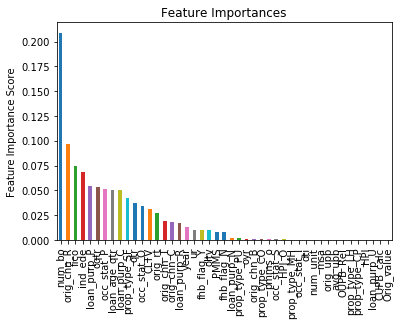

In [52]:
feat_imp = pd.Series(gb.feature_importances_, list(X_test.columns)).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

### Tuning HP of logistic regression via RandomizedSearchCV

C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.01596, std: 0.00043, params: {'logistic__penalty': 'l1', 'logistic__C': 10}, mean: 0.01598, std: 0.00047, params: {'logistic__penalty': 'l2', 'logistic__C': 1}, mean: 0.01591, std: 0.00043, params: {'logistic__penalty': 'l2', 'logistic__C': 10}, mean: 0.01596, std: 0.00052, params: {'logistic__penalty': 'l1', 'logistic__C': 0.001}, mean: 0.01595, std: 0.00041, params: {'logistic__penalty': 'l1', 'logistic__C': 1000}, mean: 0.01585, std: 0.00039, params: {'logistic__penalty': 'l2', 'logistic__C': 0.001}, mean: 0.01596, std: 0.00039, params: {'logistic__penalty': 'l1', 'logistic__C': 100}] {'logistic__penalty': 'l2', 'logistic__C': 1} 0.01597739134873591
cohen's kappa:  0.011410727872133597
             precision    recall  f1-score   support

          0       1.00      0.79      0.88    299352
          1       0.01      0.77      0.02       648

avg / total       1.00      0.79      0.88    300000



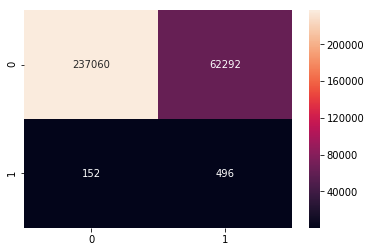

17h 33min 4s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [25]:
%%timeit -n1 -r1
pipe = Pipeline(steps=[('smote', SMOTE(ratio='minority')), ('logistic', linear_model.LogisticRegression())])
params = dict(logistic__C=[0.1, 1, 10], logistic__penalty=['l1', 'l2'])
cv_gen = StratifiedKFold(n_splits=5, random_state=0)
hp = RandomizedSearchCV(pipe, params, n_iter=6, refit=True, scoring='f1', cv=cv_gen, n_jobs=3)
hp.fit(X_train, y_train)

print(hp.cv_results_, '\n', hp.best_params_, '\n', hp.best_score_, '\n')
y_pred = hp.best_estimator_.predict(X_test)
print("cohen's kappa: ", cohen_kappa_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.show()

# best params: {'logistic__penalty': 'l2', 'logistic__C': 1} 
# best F-1 score: 0.01597739134873591
# time cost: 17.5h

### Tuning HP of gradient boost via RandomizedSearchCV

In [ ]:
%%timeit -n1 -r1
pipe = Pipeline(steps=[('smote', SMOTE(ratio='minority')), ('gb', GradientBoostingClassifier(learning_rate=0.01))])
params = dict(gb__n_estimators=list(range(20, 201, 20)), 
              gb__max_depth=list(range(2, 16, 2)),
              gb__min_samples_split=list(range(600, 1601, 200)),
              gb__min_samples_leaf=list(range(30, 71, 10)),
              gb__max_features=list(range(7,30,2)))
cv_gen = StratifiedKFold(n_splits=5, random_state=0)
hp = RandomizedSearchCV(pipe, params, n_iter=18, refit=True, scoring='f1', cv=cv_gen, n_jobs=6)
hp.fit(X_train, y_train)

print(hp.cv_results_, '\n', hp.best_params_, '\n', hp.best_score_, '\n')
y_pred = hp.best_estimator_.predict(X_test)
print("cohen's kappa: ", cohen_kappa_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.show()

# learning_rate: 0.1
# best params: {'gb__n_estimators': 20, 'gb__min_samples_split': 1200, 'gb__min_samples_leaf': 60, 'gb__max_features': 23, 'gb__max_depth': 4}
# best score: 0.02844593062255209

### Tuning HP of AdaBoost via RandomizedSearchCV

In [10]:
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "base_estimator__max_depth": list(range(2, 16, 2)),
              "base_estimator__min_samples_split": list(range(600, 1601, 200)),
              "base_estimator__min_samples_leaf": list(range(30, 71, 10)),
              "n_estimators": list(range(20, 101, 10))
             }
base_clf = DecisionTreeClassifier(random_state=11, max_features="auto")
clf = AdaBoostClassifier(base_clf, learning_rate=1)
hp = RandomizedSearchCV(clf, param_grid, n_iter=12, refit=True, n_jobs=4, scoring='f1')
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

In [ ]:
for train, test in sss.split(X_train, y_train):
    tic = time.time()
    pipeline = make_pipeline(SMOTE(ratio='minority'), hp)
    model = pipeline.fit(X_train[train], y_train[train])
    best_est = hp.best_estimator_
    prediction = best_est.predict(X_train[test])
    
    print(best_est)
    print("cohen's kappa: ", cohen_kappa_score(y_train[test], prediction))
    print(classification_report(y_train[test], prediction))
    sns.heatmap(confusion_matrix(y_train[test], prediction), annot=True, fmt="d")
    toc = time.time()
    print(toc - tic)
    print('\n')

### Backup

In [ ]:
params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
hp = RandomizedSearchCV(linear_model.LogisticRegression(), params, n_iter=4, refit=True, scoring='f1')
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for train, test in sss.split(X_train, y_train):
    tic = time.time()
    pipeline = make_pipeline(SMOTE(ratio='minority'), hp)
    model = pipeline.fit(X_train[train], y_train[train])
    best_est = hp.best_estimator_
    prediction = best_est.predict(X_train[test])
    
    toc = time.time()
    print(toc - tic)
    print('\n')

In [28]:
params = {'n_estimators': list(range(20, 101, 10)), 'max_depth': list(range(2, 16, 2)), 
          'min_samples_split': list(range(600, 1601, 200)), 'min_samples_leaf': list(range(30, 71, 10)), 
          'max_features': list(range(7,30,2))}
hp = RandomizedSearchCV(GradientBoostingClassifier(learning_rate=0.1), params, n_iter=12, refit=True, n_jobs=4, scoring='f1')
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for train, test in sss.split(X_train, y_train):
    tic = time.time()
    pipeline = make_pipeline(SMOTE(ratio='minority'), hp)
    model = pipeline.fit(X_train[train], y_train[train])
    best_est = hp.best_estimator_
    prediction = best_est.predict(X_train[test])
    
    print(best_est)
    print("cohen's kappa: ", cohen_kappa_score(y_train[test], prediction))
    print(classification_report(y_train[test], prediction))
    sns.heatmap(confusion_matrix(y_train[test], prediction), annot=True, fmt="d")
    toc = time.time()
    print(toc - tic)
    print('\n')